# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import csv
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

from zipfile import ZipFile

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [3]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'pat.txt', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb']


In [4]:
class GetData():
    
    """
    Basic class to to all the data extraction work :
    - extracts the two files
    - replaces manually entered numbers for total mass and fat mass by calculated averages if available
    - provides method to export processed data
    """
    
    def __init__(self, zip_file_name, manual_file_name):
        self.zip_file_name = zip_file_name
        self.manual_follow_up_file_name = manual_file_name
        self.daily_mass_measurements = []
        self.daily_data = []
    
    def extract(self):
        # extract data from the two files
        # first : data_BEN.zip
        
        root = os.getcwd() + '/'
        weight_file_path = root + 'tmp'

        with ZipFile(self.zip_file_name, 'r') as fichier_zip:
            print(f'Extraction fichier Zip Healthmate dans {weight_file_path}...')
            fichier_zip.extractall(path = weight_file_path)
            print(f'... Done')
        
        weight_file_csv_name = weight_file_path + '/weight.csv'
        fields = ['date', 
                  'MT', 
                  'MG']

        self.raw_from_zip = self.__extract_data(weight_file_csv_name, 
                                                fields,
                                                skip=1, 
                                                delimiter=',')  # gets a list of dictionnaries
        
        # 1/ self.raw_from_zip is a list of dictionnaries, that's the set of all mass measurements from Withings scale
        # there can be several measurements per day (and there usually are)
        
        # format is :
        # [ { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   ....,
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        # ]
                
        # second : Suivi_Poids.csv
        
        fields = ['date', 
                  'Masse Totale', 
                  'Masse Grasse', 
                  'Calories in', 
                  'Glucides', 'Lipides', 'Proteines', 
                  'Calories Exercice Brut', 'C_Ex_Cardio', 'C_Ex_Strength',
                  'Verif']
        
        self.raw_from_manual = self.__extract_data(self.manual_follow_up_file_name, 
                                                   fields,
                                                   skip=2, 
                                                   delimiter=';')  # returns and stores a list of disctionnaries
              
        
        # 2/ self.raw_from_manual is a list of dictionnaries, with one set of data per day, from a *.csv follow-up file
        
        # format is :
        # [ { 'date' : 'DD-month_name-YYYY', 'Masse Totale' : str of total mass, 'Masse Grasse' : str of fat mass,
        #     'Calories In' : str of kcals, 'Glucides' : str, 'Lipides' : str, 'Proteines' : str, 'Calories Exercice Brut': str,
        #     'C_Ex_Cardio': str, 'C_Ex_Strength': str, 'Verif': str, None: ['', '']
        #   },
        # ....
        # ]
        
        # ------------------------------
        # -- data consolidation --------
        # ------------------------------
        
        # 1/ creates an attribute self.daily_mass_measurements, which is a list of dictionnaries, containing all the mass measurements
        # per day, non empty, in float format - created from self.raw_from_zip
        
        # format is :
        
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        for cdict in self.raw_from_zip:
            cdate = self.__conv_to_date_num(cdict.get('date'))
            cmt = self.__conv_to_float(cdict.get('MT'))
            cmg = self.__conv_to_float(cdict.get('MG'))
            self.__add_daily_mass_measurement(cdate, cmt, cmg)
            
        # 2/ creates an attribute self.daily_data, which is a list of dictionnaries, containing all the measurements of the day
        # plus the calories data from the *.csv file (self.raw_from_manual)
        # if available in self.daily_mass_measurements, then the mass data in self.daily_data is overwritten by the averages
        # in self.daily_mass_measurements
        
        # format is :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        for cdict in self.raw_from_manual:
            cdate = self.__conv_to_date_str(cdict.get('date'))
            found, cmt, cmg = self.get_daily_mass_measurement(cdate)  # is the mass data in the Withings file ?
            if found:
                cmt = np.mean(cmt)
                cmg = np.mean(cmg)
            else:
                cmt = self.__conv_to_float(cdict.get('Masse Totale'))
                cmg = self.__conv_to_float(cdict.get('Masse Grasse'))
            cals_in = self.__conv_to_float(cdict.get('Calories in', '0.0'))
            glu = self.__conv_to_float(cdict.get('Glucides', '0.0'))
            lip = self.__conv_to_float(cdict.get('Lipides','0.0'))
            prot = self.__conv_to_float(cdict.get('Proteines', '0.0'))
            cals_ex = self.__conv_to_float(cdict.get('Calories Exercice Brut', '0.0'))
            cals_card = self.__conv_to_float(cdict.get('C_Ex_Cardio', '0.0'))
            cals_str = self.__conv_to_float(cdict.get('C_Ex_Strength', '0.0'))
            new_rec = dict([ ('date', cdate), 
                             ('masse_totale', cmt),
                             ('masse_grasse', cmg),
                             ('calories_in', cals_in),
                             ('glucides', glu),
                             ('lipides', lip),
                             ('proteines', prot),
                             ('calories_exercice', cals_ex),
                             ('calories_cardio', cals_card),
                             ('calories_strength', cals_str)
                             ])
            self.daily_data.append(new_rec)            
                    
    def __add_daily_mass_measurement(self, cdate : datetime.datetime, cmt : float, cmg : float):
        # utility : add cmt, cmg to the self.daily_mass_measurements records, or create it if first time
        found = False
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                self.daily_mass_measurements[i]['mt'].append(cmt)
                self.daily_mass_measurements[i]['mg'].append(cmg)
        if not found:
            new_rec = dict([ ('date', cdate), ('mt', [cmt]) , ('mg', [cmg]) ])
            self.daily_mass_measurements.append(new_rec)
            
    def get_daily_mass_measurement(self, cdate : datetime.datetime):
        # access to list of daily mass measurements
        # returns :
        # (True, list of mt measurements, list of mg measurements) if exist
        # (False, 0.0, 0.0) if does not exist
        found = False
        daily_mt = 0.0
        daily_mg = 0.0
        
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                daily_mt = daily_m_dict.get('mt')
                daily_mg = daily_m_dict.get('mg')
                
        return found, daily_mt, daily_mg
    
    def get_window_daily_mass_measurements(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of daily_mass_measurements between the two dates
        # format is, for the relevant dates :
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, daily_mt, daily_mg = self.get_daily_mass_measurement(cdate)
            if found:
                window.append( dict([ ('date',cdate), ('mt',daily_mt), ('mg', daily_mg) ]) )
                
        return window
    
    def get_daily_data(self, cdate : datetime.datetime):
        # access to list of daily data
        
        # returns :
        # (True, dict of dialy data if exist
        # (False, {}) if does not exist
        found = False
        ret_dict = {}
        
        for i, daily_m_dict in enumerate(self.daily_data):
            if daily_m_dict.get('date') == cdate:
                found = True
                ret_dict = self.daily_data[i]
                
        return found, ret_dict
    
    def get_window_daily_data(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of the daily data between the two dates
        # format is, for the relevant dates :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, cdict = self.get_daily_data(cdate)
            if found:
                window.append( cdict )
                
        return window
    
    def __extract_data(self,
                       filename, 
                       champs,
                       skip=2,
                       delimiter=','):
        """
        Helper function that reads a csv file, returns a list of dictionnaries
        Each dict is a line, ie a daily measurement, in the file.
        Skips the first line(s)
        
        Parameters :
        filename (str) : name of the *.csv file
        fieldnames (sequence) : sequence of the columns names
        skip (int) : number of lines to skip at the beginning of the file
        delimiter (str) : character used as a delimiter
        """

        data = []
        with open(filename, newline='') as csvfile:
            fichier = csv.DictReader(csvfile, fieldnames=champs, delimiter=delimiter)
            for i in range(skip):  # skip <skip> lines at the beginning of the file
                next(fichier)
            for row in fichier:
                data.append(row)

        return data
    
    def __conv_to_date_str(self, date_string : str) -> datetime.date:
        """
        helper function that converts string outputs of dates, 
        with format "YY-month_name-day", and returns a date object
        from datetime.
        """

        dict_mois = {'août' : 8, 
                     'sept.' : 9,
                     'oct.' : 10,
                     'nov.' : 11,
                     'déc.' : 12,
                     'janv.' : 1,
                     'févr.' : 2,
                     'mars' : 3,
                     'avr.' : 4,
                     'mai' : 5,
                     'juin' : 6,
                     'juil.' : 7
                    }
        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = 2000 + int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            try:
                month = dict_mois.get(d[1])
            except ValueError:
                raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_date_num(self, date_string : str) -> datetime.date:
        """
        helper function that converts a "YYYY-MM-DD" string into a date object
        """

        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_float(self, float_string:str) -> float:
        """
        conversion basique+ en float.

        renvoie 0 si string vide ou remplie d'espaces, ou string = '-'.
        """

        if type(float_string) is None:
            return 0

        float_string = float_string.replace(" ","")
        if not float_string:
            return 0
        if float_string == "-":
            return 0

        try:
            float_string = float_string.replace(" ","")
            valeur = float(float_string.replace(',','.'))
        except ValueError:
            raise NameError('une tentative de conversion en float a échouée car string non compatible')

        return valeur

In [5]:
ds = GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


In [7]:
# print(ds.daily_mass_measurements)

In [8]:
# print(ds.daily_data)

In [9]:
cdate = date(2021,11,4)
print(ds.get_daily_mass_measurement(cdate))
print(ds.get_daily_data(cdate))

(True, [67.4, 67.35, 67.35, 67.4, 67.5, 67.25, 67.35, 67.4], [8.04, 8.05, 8.05, 8.06, 8.16, 8.07, 8.09, 8.22])
(True, {'date': datetime.date(2021, 11, 4), 'masse_totale': 67.375, 'masse_grasse': 8.092500000000001, 'calories_in': 2613.0, 'glucides': 274.0, 'lipides': 74.0, 'proteines': 212.0, 'calories_exercice': 810.0, 'calories_cardio': 0, 'calories_strength': 810.0})


In [10]:
cdate = date(2010,11,1)
print(ds.get_daily_mass_measurement(cdate))
print(ds.get_daily_data(cdate))

(True, [92.95], [22.21])
(False, {})


In [11]:
cdate = date(2023,10,20)
print(ds.get_daily_mass_measurement(cdate))
print(ds.get_daily_data(cdate))

(False, 0.0, 0.0)
(False, {})


In [12]:
# print(ds.get_window_daily_mass_measurements(start_date = date(2021,10,15), end_date = datetime.date.today() ))

In [13]:
# print(ds.get_window_daily_data(start_date = date(2021,10,15), end_date = datetime.date.today() ))

# Basic display of data

We want :
- display of total mass over time, along with average over n days, and regression over m days
- idem for fat mass, body fat percentage
- display of calories, calories exercices, net cals, etc over time, along with average over n days

In [14]:
class Display():
    """
    class to provide graphical output based on data passed as a parameter
    """
    
    def __init__(self, window_daily_mass_measurements, window_daily_data):
        """Constructor. Uses the formats viewed  in the GetData class

        Args:
        
            window_daily_mass_measurements ([type]): 
            
                # format is :
                # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   ...
                # ]
                
            window_daily_data ([type]): [description]
            
                # format is :
                # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
                #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
                #     'calories_cardio': float, 'calories_strength': float },
                # ....
                # ]    
                
        """
        
        self.daily_mass_measurements = window_daily_mass_measurements
        self.daily_data = window_daily_data   
    
    def __basic_plot(self,
                     data_list, 
                     grid=True,
                     title='titre', perc=False,
                     rolling_average=False, n_avg=7, 
                     linear_regression=False, n_reg=30):
        
        """Private method for basic display of one data over time, along with rolling average and linear regression
        
        Parameters :
        ------------
        data_list (list of dictionnaries) : this is the data, format is [ { 'date' : datetime.date object, 'y' : float} ...]
        grid (bool, optional): [présence ou pas de la grille]. Defaults to True.
        title(string, optional): [titre]. Defaults to 'titre'
        rolling_average (bool, optional): [affiche ou pas la moyenne glissante]. Defaults to False.
        n_avg (int, optional): [fenêtre de calcul de la moyenne glissante]. Defaults to 7.
        linear_regression (bool, optional): [affiche ou pas la régression linéaire]. Defaults to False.
        n_reg (int, optional): [fenêtre de calcul de la régression linéaire]. Defaults to 30.

        Returns:
        --------
            [type]: [description]
        """
        
        X = [ cdict.get('date') for cdict in data_list ]
        y = [ cdict.get('y') for cdict in data_list ]
        
        if rolling_average or linear_regression:
            fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
        else:
            fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
            
        ax1.plot(X, y, color='blue', marker='x')
        ax1.set_title(title)
    
        if grid: 
            ax1.grid()
            
        # calcule le rolling average sur n_avg jours
        moy = np.zeros(shape=len(y))
        moy[0] = y[0]
        for i in range(1,len(y)):
            id = max(0, i-n_avg+1)
            moy[i] = np.mean(y[id:i])
    
        if rolling_average:
            # plot moyenne glissante sur les n_moy dernières valeurs
            ax1.plot(X, moy, color='red', marker='o')
            ax2.text(0.1,0.9,f'moyenne glissante sur {n_avg} jours')
    
        if linear_regression:
            # plot regression linéaire sur les n_reg dernières valeurs des valeurs rolling average
            X_num = np.array([ d.toordinal() for d in X]).reshape(-1,1)
            lr_model = LinearRegression().fit(X_num[-n_reg:], moy[-n_reg:])   # fit sur les n_reg dernières valeurs du rolling average
            reg_pred = lr_model.predict(X_num)
            ax1.plot(X, reg_pred, color='green', marker='+')
            pente =lr_model.coef_[0] * 30 # coefficient par mois
            if perc==True: pente *= 100
            coeff = lr_model.score(X_num[-n_reg:], moy[-n_reg:])
            ax2.text(0.1,0.8,f'régression calculée sur {n_reg} jours (de {X[-n_reg]} à {X[-1]}) sur les valeurs moyennées {n_avg} jours')
            if perc==True:
                str_pente = f'pente = {np.around(pente, decimals=3)}% / mois'
            else:
                str_pente = f'pente = {np.around(pente, decimals=3)} / mois'
            ax2.text(0.1,0.7,str_pente)
            ax2.text(0.1,0.6,f'coefficient régression = {np.around(coeff * 100,1)}%')
        
        return fig
    
    def plot_weight(self, **kwargs):
        """plot the total mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mt'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='total mass', 
                          **kwargs)
        
    def plot_fat(self, **kwargs):
        """plot the fat mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mg'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='Fat mass', 
                          **kwargs)
        
    def plot_lean_mass(self, **kwargs):
        """plot the lean mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mt')) - np.mean(cdict.get('mg'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='Lean mass', 
                          **kwargs)
        
    def plot_body_fat_percentage(self, **kwargs):
        """plot the body fat percentage data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mg')) / np.mean(cdict.get('mt')) ) ] ) for cdict in self.daily_mass_measurements if np.mean(cdict.get('mt'))>0 ]
        self.__basic_plot(data_list, 
                          title='body fat percentage', 
                          perc=True,
                          **kwargs)
        
    def plot_calories_net(self, **kwargs):
        """plot the net calories data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('calories_in')) - np.mean(cdict.get('calories_exercice'))) ] ) for cdict in self.daily_data ]
        self.__basic_plot(data_list, 
                          title='net calories', 
                          **kwargs)

# Plot de toutes les données depuis 2020

In [15]:
window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )

graph = Display(window_daily_mass_measurements, window_daily_data)

In [16]:
n_reg_list = [7, 15]

In [17]:
for n_reg in n_reg_list:
    # graph.plot_weight(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)
    pass

In [18]:
for n_reg in n_reg_list:
    # graph.plot_fat(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)
    pass

In [19]:
for n_reg in n_reg_list:
    # graph.plot_body_fat_percentage(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)
    pass

In [20]:
# graph.plot_body_fat_percentage(rolling_average=False, n_avg=15, linear_regression=False, n_reg=n_reg)

In [21]:
for n_reg in n_reg_list:
    # graph.plot_lean_mass(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)
    pass

In [22]:
# graph.plot_calories_net(rolling_average=True, n_avg=30)

# Zoom 90 jours

In [23]:
over_last_days = 90

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

graph = Display(window_daily_mass_measurements, window_daily_data)

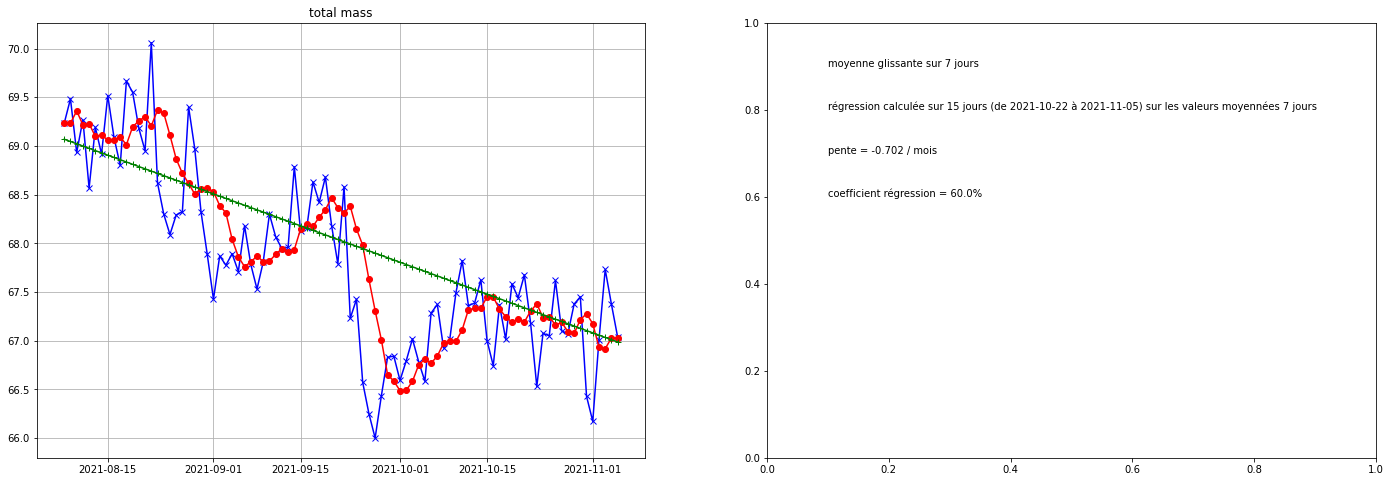

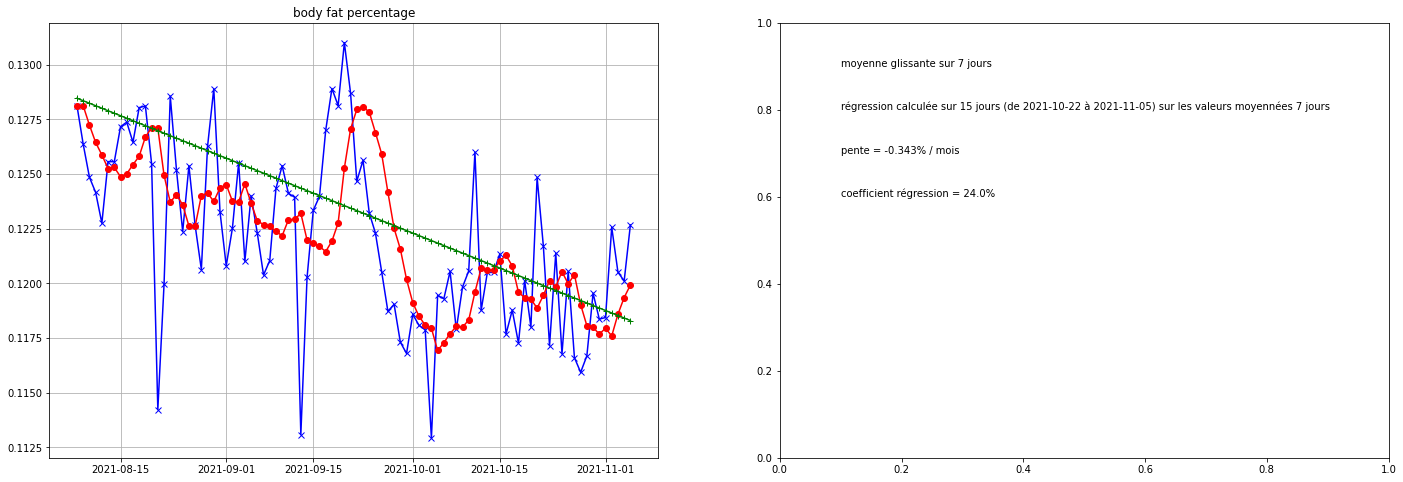

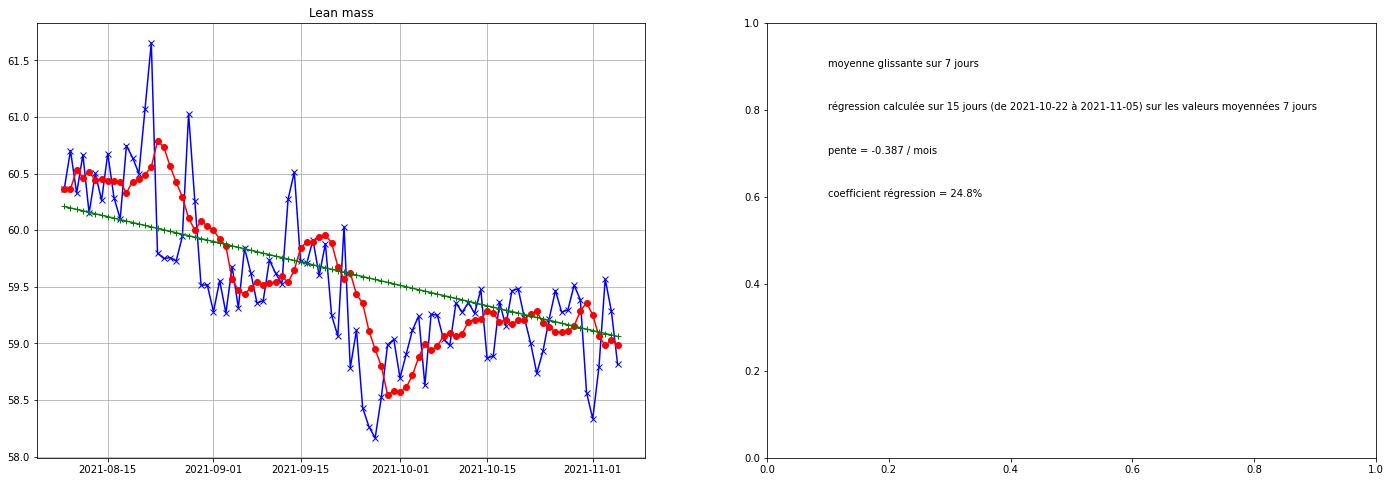

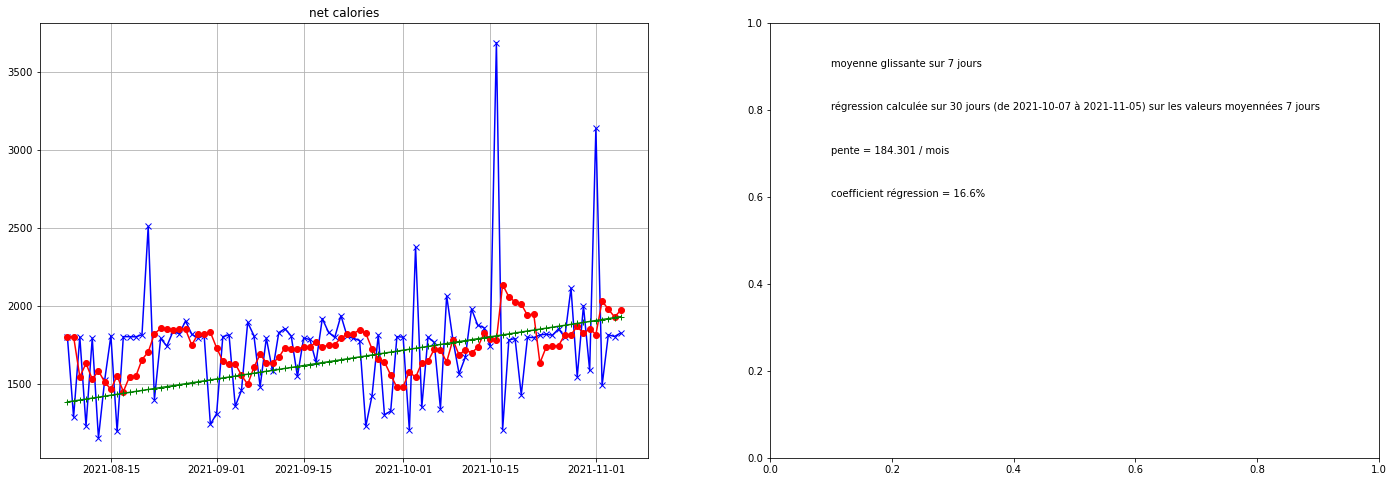

In [44]:
n_reg_list = [15]

for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_lean_mass(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    
graph.plot_calories_net(rolling_average=True, n_avg=7, linear_regression=True, n_reg=30)


# Some exploratory analysis

### First, correlation between net calories and rate of mass loss

In [25]:
class ExploratoryAnalysis():
    """
    Class that provides some analysis on the data
    """
       
    def __init__(self, window_daily_mass_measurements, window_daily_data):
        """Constructor. Uses the formats viewed  in the GetData class

        Args:
        
            window_daily_mass_measurements ([type]): 
            
                # format is :
                # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   ...
                # ]
                
            window_daily_data ([type]): [description]
            
                # format is :
                # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
                #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
                #     'calories_cardio': float, 'calories_strength': float },
                # ....
                # ]    
                
        """
        
        self.daily_mass_measurements = window_daily_mass_measurements
        self.daily_data = window_daily_data
        
    def __rolling_average(self, x, n_avg=7):
        """takes a np.array of values, and returns the np.array of the rolling averages
        
        Parameters:
        -----------
        x (np.array) : the array of values on which to calculate the averages
        n_avg (int) : the length of the sequences to calculate averages on
        
        raises an error if n_avg > length of x
        
        Returns:
        --------
        x_avg : a np.array of the same length as x
        x_avg[i] is the average of values x[max(0,i-n_avg)] to x[i-1] included
        NB : the first n_avg-1 values in x_avg are averages calculated over shorter periods than n_avg
        """
        
        if n_avg > len(x):
            raise NameError('attempting to calculate rolling averages of size superior to the length of data')
        else:
            x_avg = np.zeros(shape=len(x))
            x_avg[0] = x[0]
            for i in range(1,len(x)):
                id = max(0, i-n_avg)
                x_avg[i] = np.mean(x[id:i])
            return x_avg
        
    def test__rolling__average(self):
            
        x = np.array([ 1.0, 5.0, 6.0, 7.0, 8.0, 0.0, 2.0, 5.0, 3.0, 4.0, 5.0, 8.0 ])
        # for n_avg = 3 :
        x_avg_expected = np.array([ 1.0, 1.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.333333, 2.333333, 3.3333333, 4.0, 4.0])
            
        x_avg = self.__rolling_average(x, n_avg=3)
        
        print(f'expecting {x_avg_expected}')
        print(f'calculating {x_avg}')
        
    def __regression_values(self, y, n_reg=30):
        """takes a np.array of values y, and returns the np.array of regression rates over intervals of size n_reg

        Args:
        -----
            y ([np.array]): values to calculate the regression rate upon.
            n_reg ([int]): length of the regression
            
        Returns:
        --------
            y_rate ([np.array]) : regression rates.
            
        y_rate is a np.array of the same length as y
        y_rate[i] is :
        - the slope of the regression of y[i-n_reg], y[i-n_reg+1], ... , y[i-1] vs [0,1,...,n_reg-1] when i >= n_reg,
        - the slope of regression of y[0], ... , y[i-1] vs [0, ... i-1] when 1 =< i < n_reg
        - y_rate[0] = y[1] - y[0]
        """
        
        if n_reg > len(y):
            raise NameError('attempting to calculate regressions of sample size superior to the length of data')
        else:
            y_rate = np.zeros(shape=len(y))
            
            x = np.array([ k for k in range(n_reg)]).reshape(-1,1)
            for i in range(n_reg, len(y)):
                lr_model = LinearRegression().fit(x, y[i-n_reg:i])
                y_rate[i] = lr_model.coef_[0] * 30 # monthly rate of change
                # print(f'------- calcule indice {i} ---------')
                # print(f'x = {x}')
                # print(f'y = {y[i-n_reg:i]}')
                
            for i in range(1, n_reg):
                x = np.array([ k for k in range(i)]).reshape(-1,1)
                lr_model = LinearRegression().fit(x, y[:i])
                y_rate[i] = lr_model.coef_[0] * 30 # monthly rate of change
                # print(f'------- calcule indice {i} ---------')
                # print(f'x = {x}')
                # print(f'y = {y[:i]}')
                
            y_rate[0] = (y[1] - y[0]) * 30
            
            return y_rate
        
    def test_regression_values(self):
        
        y = np.array([ 1.0, 5.0, 8.0, 9.0, 12.0, 0.0, 2.0, 5.0, 3.0, 4.0, 5.0, 8.0, 12.0, 13.0, 20.0 ])
        # for n_reg = 5 :
        y_rate_expected = np.array([ 4.0, 0.0, 4.0, 3.5, 2.7, 2.6, -0.6, -2.1, -1.8, -1.3, 0.9, 0.5, 0.8, 2.2, 2.5]) * 30
            
        y_rate = self.__regression_values(y, n_reg=5)
        
        print(f'expecting {y_rate_expected}')
        print(f'calculating {y_rate}')
    
    def __basic_scatter(self,
                         data_list,
                         grid=True,
                         title = 'titre'):
        """ Basic display of scatter plot of two series, with a third one used as color legend

        Args:
        -----
            data_list ([dict]): list of dictionnary of datas to display. Format is the following :
                [ { 'date' : datetime.date object, key1(str) : float , key2(str) : float, key3(str) : float } ...]
                key1, key2 and key3 are strings, they are the names of the series to display
                key1.values are x coordinate of data points, 
                key2.values are y coordinate of data points,
                key3.values are values to be used as color        
            grid (bool, optional): [description]. Defaults to True.
            title (str, optional): [description]. Defaults to 'titre'.
            
        Returns : 
        ---------
            none
            
        The method will extract the names of the series, use them on the plot, extract the series, and draw the scatter plot
        """
        
        keys_list = list(data_list[0].keys())
        # print(keys_list)
        name_x = keys_list[1]
        x = np.array([ cdict.get(name_x) for cdict in data_list])
        name_y = keys_list[2]
        y = np.array([ cdict.get(name_y) for cdict in data_list])
        name_z = keys_list[3]
        z = np.array([ cdict.get(name_z) for cdict in data_list])
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        im = ax.scatter(x, y, c=z)
        fig.colorbar(im, ax=ax)
        
        if grid: ax.grid()
        if title: ax.set_title(title)
        
        ax.set_xlabel(name_x)
        ax.set_ylabel(name_y)
        
        return fig
    
    def draw_correlation(self,
                         dates,
                         name_x, name_y, name_z,
                         x,y,z,
                         mode_3d = False,
                         title = "",
                         grid=True,
                         **kwargs):
        """ method to draw the correlation between x and y, as z as color or altitude (in 3D mode)

        Args:
        -----
            dates ([datetime.date]) : list of datetime.date objects
            name_x ([string]): name of the x serie
            name_y ([string]): name of the y serie
            name_z ([string]): name of the z serie
            x,y,z ([np.arrays]) : arrays of floats to use for the plot
            mode_3d (bool, optional): if True, will use 3D scatter method. Defaults to False.
            title (str, optional): title of the plot. Defaults to "".
        """        
        
        # basic checks
        if (len(x) != len(y)) or (len(x) != len(z)) or (len(y) != len(z)):
            raise NameError('Attempting to draw series of different lengths')
            exit
        
        # create list of dictionnaries to pass to the scatter method
        data_list=[]
        for i in range(len(x)):
            cdict = dict([('date',dates[i]), 
                          (name_x, x[i]), 
                          (name_y, y[i]), 
                          (name_z, z[i]) 
                         ])
            data_list.append(cdict)
            
        # call plot method
        self.__basic_scatter(data_list, title=title, grid=grid, **kwargs)
        
    def test_draw_correlation(self):
        """Test method
        """
        
        dates = [ cdict.get('date') for cdict in self.daily_data ]
        name_x = 'masse_totale'
        name_y = 'masse_grasse'
        name_z = 'masse_totale'
        x = np.array([ cdict.get(name_x) for cdict in self.daily_data ])
        y = np.array([ cdict.get(name_y) for cdict in self.daily_data ])
        z = np.array([ cdict.get(name_z) for cdict in self.daily_data ])
        title = 'correlation mt vs mg'
        name_z = 'masse_totale_c'
        self.draw_correlation(dates, name_x=name_x, name_y=name_y, name_z=name_z, x=x, y=y, z=z, title=title)
    
    def __basic_scatter2(self,
                        data_list, 
                        grid=True,
                        title='titre',
                        time_horizon=7
                        ):
        
        """Private method for basic scatterplot of two data, using a third one for color
        
        Parameters :
        ------------
        data_list (list of dictionnaries) : this is the data, format is 
            [ { 'date' : datetime.date object, 'x' : float , 'y' : float, 'c' : float } ...]
            x,y coordinates of data points, c float to be used as color
        grid (bool, optional): [présence ou pas de la grille]. Defaults to True.
        title(string, optional): [titre]. Defaults to 'titre'
        time_horizon (int, optional) : Number to be used to calculate averages on x and y. Defaults to 7.

        Returns:
        --------
        fig, ax : scatter plot
        """
        
        dates = [ cdict.get('date') for cdict in data_list ]
        dates_num = [ d.toordinal() for d in dates]
        x = [ cdict.get('x') for cdict in data_list ]
        y = [ cdict.get('y') for cdict in data_list ]
        color = [ cdict.get('c') for cdict in data_list ]
        
        def roll_avg(x, n_avg=time_horizon):
            # plot moyenne glissante sur les n_moy dernières valeurs
            x_avg = np.zeros(shape=len(x))
            x_avg[0] = x[0]
            for i in range(1,len(x)):
                id = max(0, i-n_avg+1)
                x_avg[i] = np.mean(x[id:i])
            return x_avg
        
        x_avg = roll_avg(x, time_horizon)
        y_avg = roll_avg(y, time_horizon)
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
        im = ax1.scatter(x_avg, y_avg, c=color)
        fig.colorbar(im, ax=ax1)
        
        if grid: ax1.grid()
        if title: ax1.set_title(title)
        
        ax2.text(0.1,0.9,f'dates de {dates[0]} à {dates[-1]} ({len(dates)} jours)')
        ax2.text(0.1,0.8,f'data moyennées sur {time_horizon} jours')
                
        return fig
    
    def correlate_mt_mg(self, **kwargs):
        
        data_list = [ dict( [ ('date', cdict.get('date')), 
                              ('x', np.mean(cdict.get('mt'))),
                              ('y', np.mean(cdict.get('mg'))),
                              ('c', np.mean(cdict.get('mt'))) 
                            ] ) for cdict in self.daily_mass_measurements ]
                     
        self.__basic_scatter2(data_list, 
                             title='correlate fat mass vs total mass', 
                             **kwargs)
        
    def correlate_bfperc_mt(self,
                            **kwargs):
        
        data_list = [ dict( [ ('date', cdict.get('date')), 
                             ('y', np.mean(cdict.get('masse_grasse')) / np.mean(cdict.get('masse_totale'))),
                             ('x', np.mean(cdict.get('masse_totale'))),
                             ('c', np.mean(cdict.get('masse_totale'))) 
                            ] ) for cdict in self.daily_data ]
        
        self.__basic_scatter2(data_list,
                             title='body fat % vs total mass',
                             **kwargs)
        
    def correlate_bfperc_rate_c_net(self,
                                    n_avg = 7,
                                    n_reg = 30,
                                    **kwargs):
        
        """
        NB : validé sous Excel Suivi_Poids.xls"""
        
        dates = np.array([ cdict.get('date') for cdict in self.daily_data ])  # get dates
        bfperc = np.array([ cdict.get('masse_grasse')/cdict.get('masse_totale') for cdict in self.daily_data ])  # calculate daily values of body fat percentage
        c_net = np.array([ cdict.get('calories_in')-cdict.get('calories_exercice') for cdict in self.daily_data ]) # calculate daily values of calories net
        
        bfperc_avg = self.__rolling_average(bfperc, n_avg) # calculate the averages of bfperc over n_avg days
        c_net_avg = self.__rolling_average(c_net, n_avg) # calculate the averages of c_net over n_avg days
        
        bfperc_avg_rate = self.__regression_values(bfperc_avg, n_reg)  # calculate the rate of change of bfperc_avg over n_reg days
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
        dates = dates[n_avg+n_reg:]
        bfperc = bfperc[n_avg+n_reg:]
        bfperc_avg = bfperc_avg[n_avg+n_reg:]
        bfperc_avg_rate = bfperc_avg_rate[n_reg+n_avg:]
        c_net_avg = c_net_avg[n_avg+n_reg:]
        
        ax.set_title(f'{n_reg}-day change rate of {n_avg}-day averaged bf% values, vs {n_avg}-day average calories net')
        im = ax.scatter(c_net_avg, bfperc_avg_rate, c=bfperc_avg)
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(f'{n_avg}-day average of calories net')
        ax.set_ylabel(f'{n_reg}-day change rate of {n_avg}-day body fat percentage')
        ax.grid(True)
        
        plt.show()
        
    def correlate_mt_rate_c_net(self,
                                n_avg=7,
                                n_reg=30,
                                **kwargs):
        
        dates = np.array([ cdict.get('date') for cdict in self.daily_data ])  # get dates
        mt = np.array([ cdict.get('masse_totale') for cdict in self.daily_data ])  # calculate daily values of total mass
        c_net = np.array([ cdict.get('calories_in')-cdict.get('calories_exercice') for cdict in self.daily_data ]) # calculate daily values of calories net
        
        mt_avg = self.__rolling_average(mt, n_avg) # calculate the averages of total mass mt over n_avg days
        c_net_avg = self.__rolling_average(c_net, n_avg) # calculate the averages of c_net over n_avg days
        
        mt_avg_rate = self.__regression_values(mt_avg, n_reg)  # calculate the rate of change of averaged total mass over n_reg days
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
        dates = dates[n_avg+n_reg:]
        mt = mt[n_avg+n_reg:]
        mt_avg = mt_avg[n_avg+n_reg:]
        mt_avg_rate = mt_avg_rate[n_reg+n_avg:]
        c_net_avg = c_net_avg[n_avg+n_reg:]
        
        ax.set_title(f'{n_reg}-day change rate of {n_avg}-day averaged total mass values, vs {n_avg}-day average calories net')
        im = ax.scatter(c_net_avg, mt_avg_rate, c=mt_avg)
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(f'{n_avg}-day average of calories net')
        ax.set_ylabel(f'{n_reg}-day change rate of {n_avg}-day total mass')
        ax.grid(True)
        
        plt.show()
  
    def correlate_lean_mass_rate_c_net(self,
                                n_avg=7,
                                n_reg=30,
                                **kwargs):
        
        dates = np.array([ cdict.get('date') for cdict in self.daily_data ])  # get dates
        mt = np.array([ cdict.get('masse_totale') for cdict in self.daily_data ])  # calculate daily values of total mass
        lm = np.array([ cdict.get('masse_totale')-cdict.get('masse_grasse') for cdict in self.daily_data ])  # calculate daily values of lean mass
        c_net = np.array([ cdict.get('calories_in')-cdict.get('calories_exercice') for cdict in self.daily_data ]) # calculate daily values of calories net
        
        lm_avg = self.__rolling_average(lm, n_avg) # calculate the averages of lean mass lm over n_avg days
        mt_avg = self.__rolling_average(mt, n_avg) # calculate the averages of total mass mt over n_avg days
        c_net_avg = self.__rolling_average(c_net, n_avg) # calculate the averages of c_net over n_avg days
        
        lm_avg_rate = self.__regression_values(lm_avg, n_reg)  # calculate the rate of change of averaged total mass over n_reg days
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
        dates = dates[n_avg+n_reg:]
        mt = mt[n_avg+n_reg:]
        mt_avg = mt_avg[n_avg+n_reg:]
        lm = lm[n_avg+n_reg:]
        lm_avg = lm_avg[n_avg+n_reg:]
        lm_avg_rate = lm_avg_rate[n_avg+n_reg:]
        
        c_net_avg = c_net_avg[n_avg+n_reg:]
        
        ax.set_title(f'{n_reg}-day change rate of {n_avg}-day averaged lean mass values, vs {n_avg}-day average calories net')
        im = ax.scatter(c_net_avg, lm_avg_rate, c=mt_avg)
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(f'{n_avg}-day average of calories net')
        ax.set_ylabel(f'{n_reg}-day change rate of {n_avg}-day total mass')
        ax.grid(True)
        
        plt.show()

# Analyse sur 360 jours

In [26]:
over_last_days = 360

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

expl = ExploratoryAnalysis( window_daily_mass_measurements, window_daily_data)

In [27]:
# expl.test_draw_correlation()

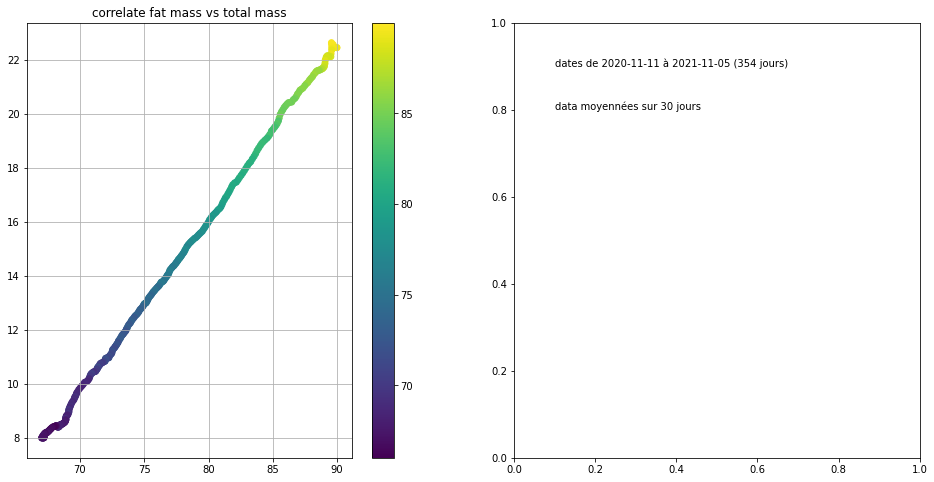

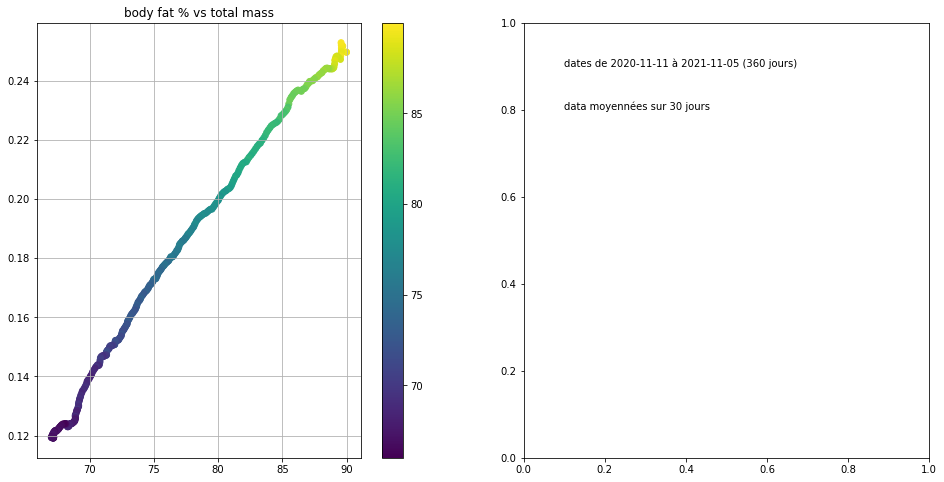

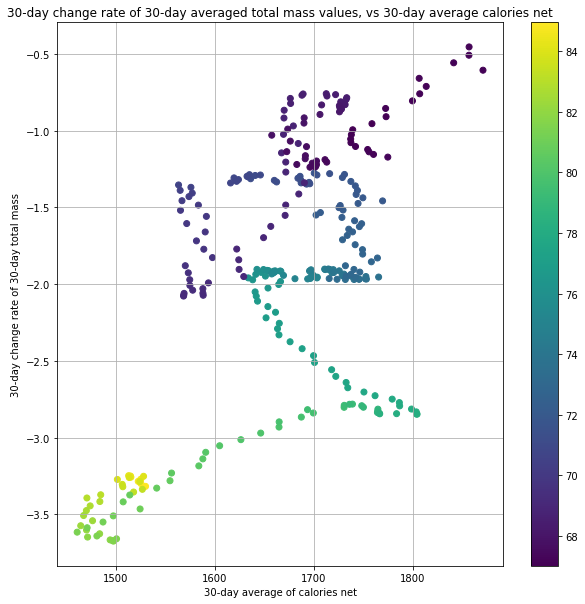

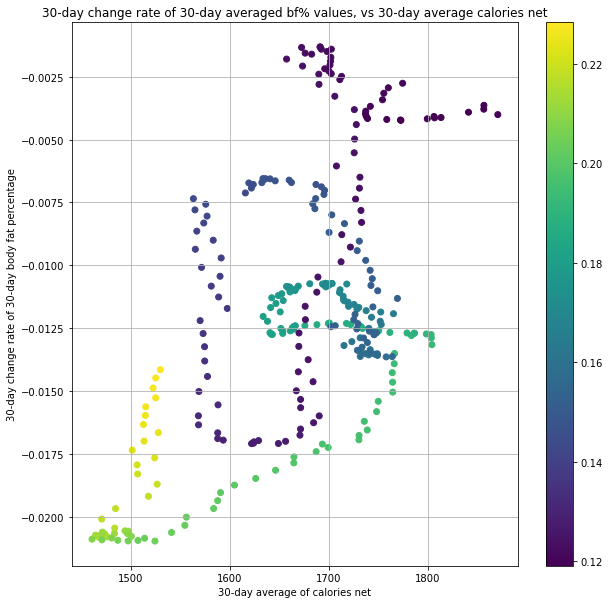

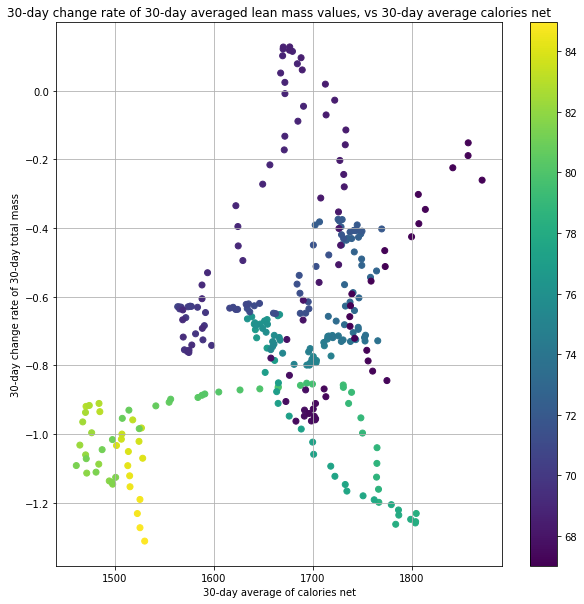

In [28]:
expl.correlate_mt_mg(time_horizon=30)

expl.correlate_bfperc_mt(time_horizon=30)

# correlate between total mass change rate and average net calories

expl.correlate_mt_rate_c_net(n_reg=30, n_avg=30)

# correlate between body fat change rate and average net calories

expl.correlate_bfperc_rate_c_net(n_reg=30, n_avg=30)

# correlate between lean mass change rate and average net calories

expl.correlate_lean_mass_rate_c_net(n_reg=30, n_avg=30)

# Analyse sur 120 jours

In [29]:
over_last_days = 120

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

expl = ExploratoryAnalysis( window_daily_mass_measurements, window_daily_data)

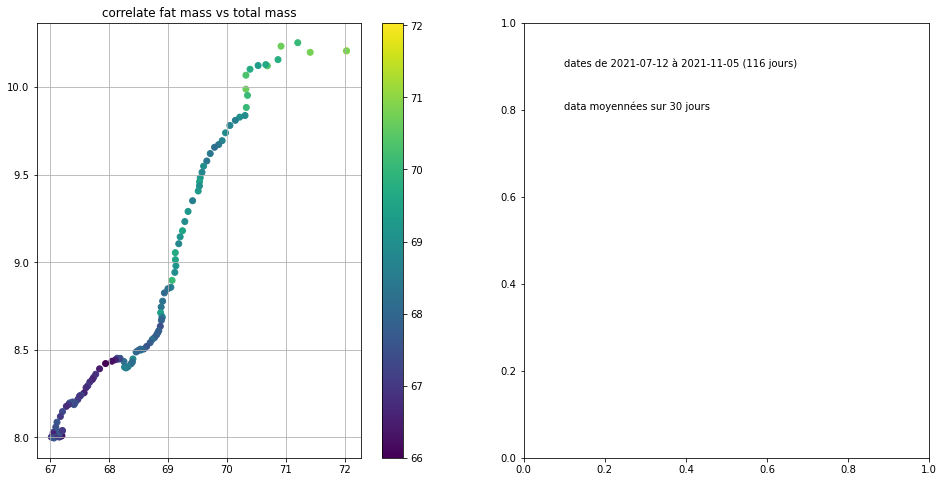

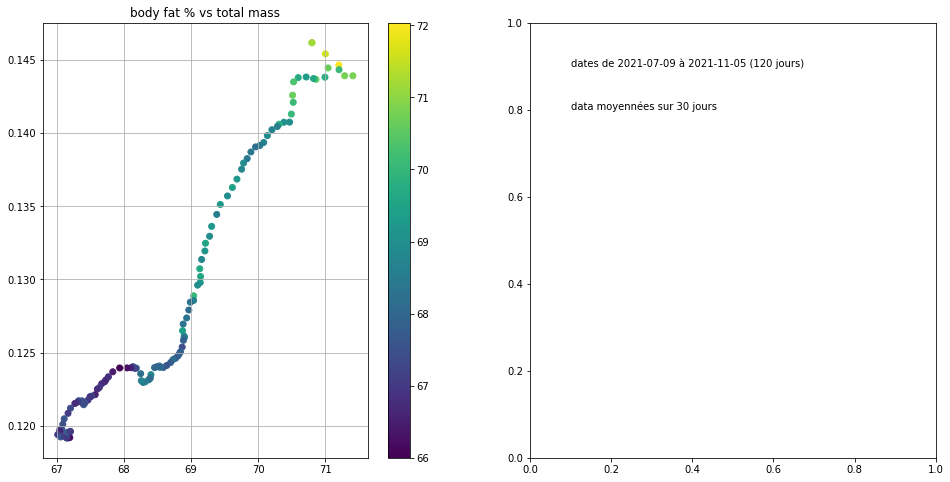

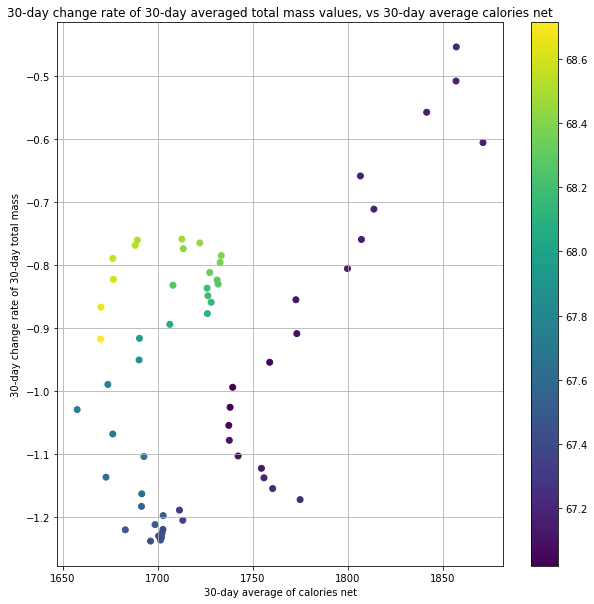

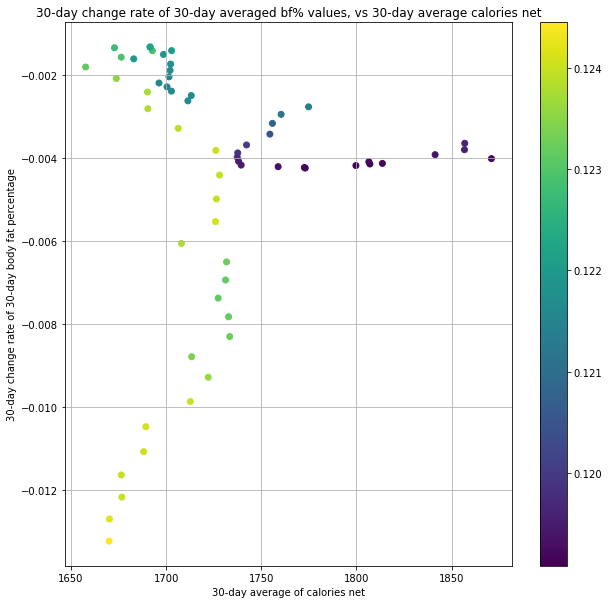

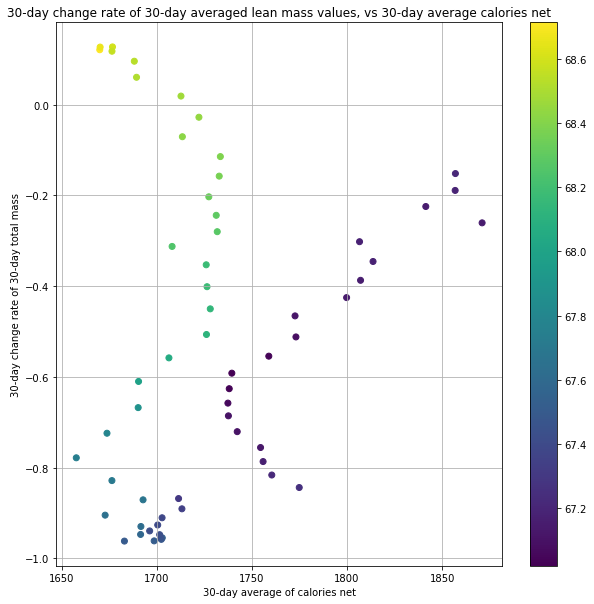

In [30]:
expl.correlate_mt_mg(time_horizon=30)

expl.correlate_bfperc_mt(time_horizon=30)

expl.correlate_mt_rate_c_net(n_reg=30, n_avg=30)

expl.correlate_bfperc_rate_c_net(n_reg=30, n_avg=30)

expl.correlate_lean_mass_rate_c_net(n_reg=30, n_avg=30)

# CONCLUSIONS :
- sur les 30 derniers jours, on voit que la perte de masse sèche devrait s'arrêter autour de 1900 kcals net / jour
- mais que l'on devrait malgré tout continuer à perdre du bf% (autour de -0.3% / mois)
- rôle de l'exercice ??

# Quels horizons de temps ? Assez grand pour effacer le bruit, assez petit pour capturer des informations => Fourier

In [31]:
from scipy.fft import fft, fftfreq

In [32]:
X_dict = ds.get_window_daily_data( start_date = datetime.date(2020,9,1),
                                  end_date = datetime.date.today())

mt = np.array([ cdict.get('masse_totale') for cdict in X_dict])

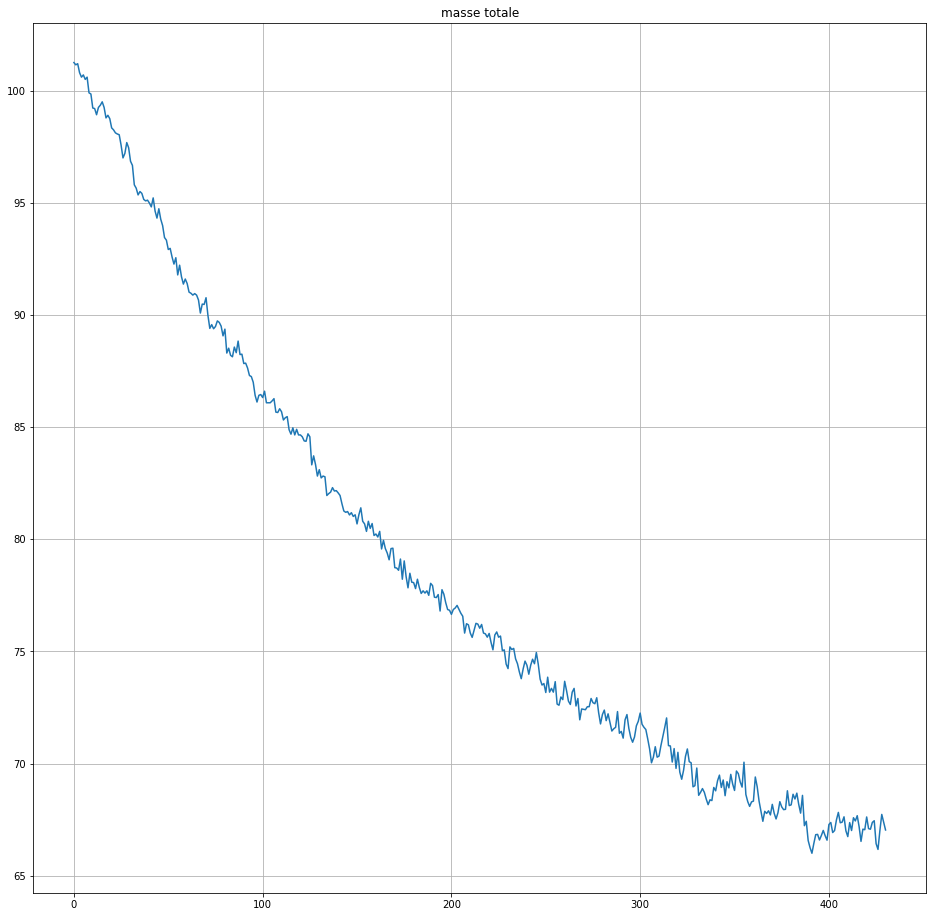

In [33]:
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.grid()
ax.plot(mt)
ax.set_title('masse totale')
plt.show()

In [34]:
N = len(mt)
T = 1.0  # sampling period = 1 day

x = np.linspace(0.0, N*T, N, endpoint=False)

In [35]:
mtf = fft(mt)

In [36]:
xf = fftfreq(N, T)[:N//2]

In [37]:
xf

array([0.        , 0.00232019, 0.00464037, 0.00696056, 0.00928074,
       0.01160093, 0.01392111, 0.0162413 , 0.01856148, 0.02088167,
       0.02320186, 0.02552204, 0.02784223, 0.03016241, 0.0324826 ,
       0.03480278, 0.03712297, 0.03944316, 0.04176334, 0.04408353,
       0.04640371, 0.0487239 , 0.05104408, 0.05336427, 0.05568445,
       0.05800464, 0.06032483, 0.06264501, 0.0649652 , 0.06728538,
       0.06960557, 0.07192575, 0.07424594, 0.07656613, 0.07888631,
       0.0812065 , 0.08352668, 0.08584687, 0.08816705, 0.09048724,
       0.09280742, 0.09512761, 0.0974478 , 0.09976798, 0.10208817,
       0.10440835, 0.10672854, 0.10904872, 0.11136891, 0.1136891 ,
       0.11600928, 0.11832947, 0.12064965, 0.12296984, 0.12529002,
       0.12761021, 0.12993039, 0.13225058, 0.13457077, 0.13689095,
       0.13921114, 0.14153132, 0.14385151, 0.14617169, 0.14849188,
       0.15081206, 0.15313225, 0.15545244, 0.15777262, 0.16009281,
       0.16241299, 0.16473318, 0.16705336, 0.16937355, 0.17169

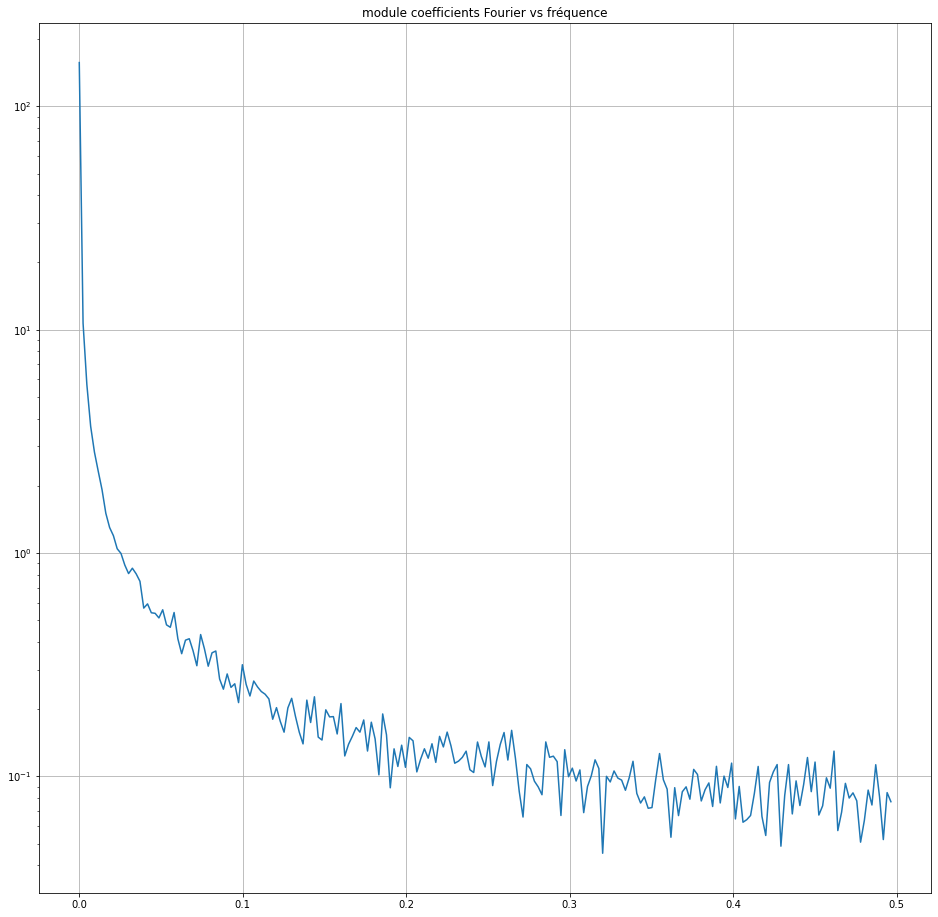

In [38]:
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.grid()
ax.plot(xf, 2.0/N*np.abs(mtf[0:N//2]))
ax.set_yscale('log')
ax.set_title('module coefficients Fourier vs fréquence')
ax.grid(True)

In [39]:
print(2.0/N*np.abs(mtf[0:N//2]))

[1.57068686e+02 1.06929834e+01 5.67924725e+00 3.69356648e+00
 2.82951910e+00 2.32342269e+00 1.92091823e+00 1.50639906e+00
 1.30050319e+00 1.19571414e+00 1.04485683e+00 9.95534877e-01
 8.83497152e-01 8.08833344e-01 8.54832978e-01 8.06695981e-01
 7.46991557e-01 5.66669128e-01 5.91771053e-01 5.40019885e-01
 5.36907608e-01 5.12074032e-01 5.56907899e-01 4.76759988e-01
 4.64975664e-01 5.41470539e-01 4.12643527e-01 3.54079246e-01
 4.07080718e-01 4.13128847e-01 3.64966952e-01 3.12761573e-01
 4.31350758e-01 3.72477750e-01 3.11276912e-01 3.57288429e-01
 3.64075952e-01 2.72778982e-01 2.45611597e-01 2.87384397e-01
 2.50223307e-01 2.59711086e-01 2.13855989e-01 3.16103229e-01
 2.58008736e-01 2.28916330e-01 2.67080487e-01 2.51398976e-01
 2.39708377e-01 2.33185004e-01 2.22050568e-01 1.80145754e-01
 2.03044123e-01 1.76134230e-01 1.57656804e-01 2.02496655e-01
 2.23511685e-01 1.85605059e-01 1.57715159e-01 1.39703615e-01
 2.19428558e-01 1.74174654e-01 2.27093495e-01 1.49842199e-01
 1.45372613e-01 1.985418

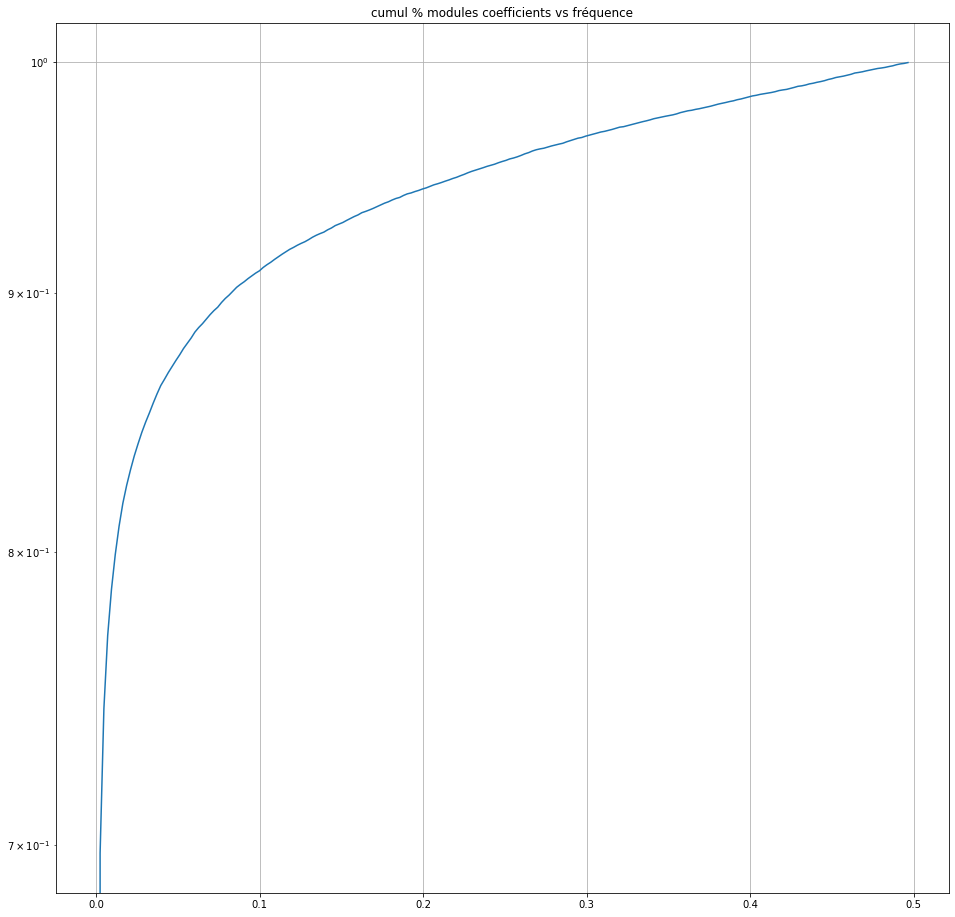

In [40]:
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.grid()
ampl = 2.0/N*np.abs(mtf[0:N//2])
cumul = [ np.sum(ampl[:i]) for i in range(N//2) ] / np.sum(ampl)
ax.plot(xf, cumul)
ax.set_yscale('log')
ax.set_title('cumul % modules coefficients vs fréquence')
ax.grid(True)

In [41]:
cumul

array([0.        , 0.69741066, 0.74488925, 0.77010604, 0.78650608,
       0.79906961, 0.80938598, 0.81791517, 0.82460383, 0.83037828,
       0.83568744, 0.84032678, 0.84474712, 0.84866999, 0.85226134,
       0.85605694, 0.8596388 , 0.86295557, 0.86547167, 0.86809923,
       0.87049701, 0.87288097, 0.87515466, 0.87762742, 0.87974431,
       0.88180888, 0.8842131 , 0.8860453 , 0.88761747, 0.88942498,
       0.89125934, 0.89287985, 0.89426856, 0.89618383, 0.89783769,
       0.89921981, 0.90080623, 0.90242279, 0.90363397, 0.90472453,
       0.90600056, 0.90711159, 0.90826475, 0.90921431, 0.91061786,
       0.91176346, 0.91277989, 0.91396577, 0.91508202, 0.91614636,
       0.91718174, 0.91816768, 0.91896756, 0.91986911, 0.92065118,
       0.9213512 , 0.92225032, 0.92324274, 0.92406686, 0.92476714,
       0.92538745, 0.92636175, 0.92713511, 0.92814344, 0.92880877,
       0.92945425, 0.9303358 , 0.93115524, 0.93197709, 0.9326643 ,
       0.93360433, 0.93415216, 0.93477017, 0.9354408 , 0.93617

In [42]:
seuils = [0.85, 0.90, 0.95, 0.99]
for s in seuils:
    id = list(np.where(cumul >= s, True, False)).index(True)
    print(f'Pour cumul >= {s}, on a frequence max = {xf[id]}, période = {N/2 * xf[id]} jours')

Pour cumul >= 0.85, on a frequence max = 0.03248259860788863, période = 7.0 jours
Pour cumul >= 0.9, on a frequence max = 0.08352668213457076, période = 18.0 jours
Pour cumul >= 0.95, on a frequence max = 0.22505800464037123, période = 48.5 jours
Pour cumul >= 0.99, on a frequence max = 0.4385150812064965, période = 94.5 jours


# Conclusion de l'analyse de Fourier :

- 85% du signal est porté par des composantes de période >= 7 jours
- 90% du signal est porté par des composantes de période >= 15 jours

On peut donc utiliser des moyennes sur 7 et 15 jours